# Overview

- Use [Langchain](https://python.langchain.com/en/latest/index.html) to <font color='orange'> build a chatbot that can answer questions about books or any pdf files.
- **<font color='orange'>Flexible and customizable RAG pipeline (Retrieval Augmented Generation)</font>**
- Experiment with various LLMs (Large Language Models)
- Use [FAISS vector store](https://python.langchain.com/docs/integrations/vectorstores/faiss) to store text embeddings created with [Sentence Transformers](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) from 🤗. FAISS runs on GPU and it is much faster than Chroma
- Use [Retrieval chain](https://python.langchain.com/docs/modules/data_connection/retrievers/) to retrieve relevant passages from embedded text
- Summarize retrieved passages
- Leverage Kaggle dual GPU (2 * T4) with [Hugging Face Accelerate](https://huggingface.co/docs/accelerate/index)
- Chat UI with [Gradio](https://www.gradio.app/guides/quickstart)

**<font color='green'>No need to create any API key to use this notebook! Everything is open source.</font>**


### Models

- [TheBloke/wizardLM-7B-HF](https://huggingface.co/TheBloke/wizardLM-7B-HF)
- [daryl149/llama-2-7b-chat-hf](https://huggingface.co/daryl149/llama-2-7b-chat-hf)
- [daryl149/llama-2-13b-chat-hf](https://huggingface.co/daryl149/llama-2-13b-chat-hf)
- [mistralai/Mistral-7B-Instruct-v0.2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2)

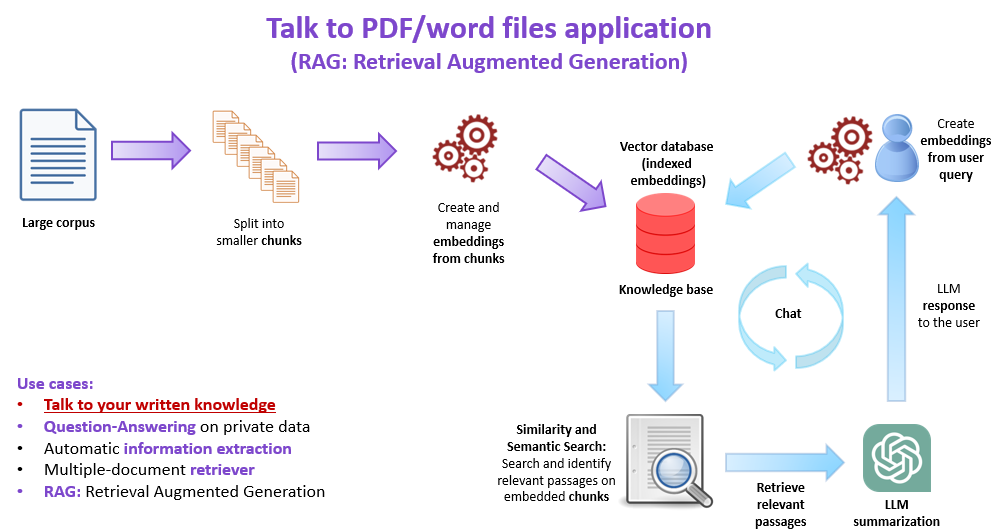

img source: HinePo

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4e9cca5e-c879-c37c-f216-60120f93ff64)
GPU 1: Tesla T4 (UUID: GPU-ff020dfb-119d-1972-9422-ec00a9cf9d42)


# Installs

In [2]:
#The NVIDIA System Management Interface (nvidia-smi) is a command line utility, based on top of the NVIDIA Management Library (NVML), intended to aid in the management and monitoring of NVIDIA GPU devices.
#Sentence Transformers (a.k.a. SBERT) is the go-to Python module for accessing, using, and training state-of-the-art text and image embedding models.
#LangChain is a framework for developing applications powered by large language models (LLMs).
#tiktoken is a fast open-source tokenizer by OpenAI.
#pypdf. pypdf is a free and open-source pure-python PDF library capable of splitting, merging, cropping, and transforming the pages of PDF files.
#Faiss is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size.
#Instructor-embedding: an instruction-finetuned text embedding model that can generate text embeddings tailored to any task (e.g., classification, retrieval, clustering, text evaluation, etc.) and domains (e.g., science, finance, etc.) by simply providing the task instruction, without any finetuning.
#A Transformer is a type of deep learning architecture that uses an attention mechanism to process text sequences. 
#Accelerate was created for PyTorch users who like to write the training loop of PyTorch models but are reluctant to write and maintain the boilerplate code needed to use multi-GPUs/TPU/fp16.
#Bitsandbytes is a lightweight wrapper around CUDA custom functions, in particular 8-bit optimizers and quantization functions.
#LangChain Community contains third-party integrations that implement the base interfaces defined in LangChain Core, making them ready-to-use in any LangChain application.

In [3]:

# Install the desired version of sentence_transformers within the virtual environment
!pip install sentence_transformers==2.2.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=61c73a69d077d72beda40901e8756a1275bd886cfb6f6fa639b89ef8c3763920
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [4]:

# Clear the output to keep the notebook clean
from IPython.display import clear_output
clear_output()


In [6]:
! pip install -qq -U langchain

In [7]:
! pip install -qq -U tiktoken

In [8]:
! pip install -qq -U pypdf

In [9]:
! pip install -qq -U faiss-gpu

In [10]:
! pip install -qq -U InstructorEmbedding 

In [11]:
! pip install -qq -U transformers 

In [12]:
! pip install -qq -U accelerate

In [13]:
! pip install -qq -U bitsandbytes

In [14]:
!pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.9 MB/s eta 0:00:00a 0:00:01


# Imports

In [15]:
%%time

import warnings
warnings.filterwarnings("ignore")

CPU times: user 56 µs, sys: 0 ns, total: 56 µs
Wall time: 59.4 µs


In [16]:
# Importing the os module for interacting with the operating system
import os

# Importing the glob module to find all the pathnames matching a specified pattern
import glob

# Importing the textwrap module for formatting text
import textwrap

# Importing the time module to handle time-related tasks
import time

# Importing the langchain module for building language model chains
import langchain


In [17]:
# Importing PyPDFLoader for loading PDF documents
from langchain.document_loaders import PyPDFLoader

# Importing DirectoryLoader for loading all documents from a directory
from langchain.document_loaders import DirectoryLoader


In [18]:
### Importing modules for text splitting
from langchain.text_splitter import RecursiveCharacterTextSplitter

### Importing modules for prompts and LLM chains
from langchain import PromptTemplate, LLMChain


In [19]:
### Importing modules for vector stores
from langchain.vectorstores import FAISS

### Importing modules for models
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceInstructEmbeddings

### Importing modules for retrievers
from langchain.chains import RetrievalQA


In [20]:
# Importing the torch module for working with PyTorch, an open source machine learning library
import torch

# Importing the transformers module for working with Transformer models
import transformers

# Importing specific classes and functions from the transformers module
from transformers import (
    AutoTokenizer,        # For loading pre-trained tokenizers
    AutoModelForCausalLM, # For loading pre-trained causal language models
    BitsAndBytesConfig,   # For configuring quantization settings for models
    pipeline              # For creating inference pipelines
)

# Clearing the output (commonly used in Jupyter notebooks)
from IPython.display import clear_output
clear_output()


In [21]:
# Printing the versions of the imported libraries
print('langchain:', langchain.__version__)
print('torch:', torch.__version__)
print('transformers:', transformers.__version__)

langchain: 0.2.3
torch: 2.1.2
transformers: 4.41.2


In [22]:
# Finding and sorting all the file paths in the specified directory
sorted(glob.glob('/kaggle/input/all-books/*'))

['/kaggle/input/all-books/Inferno-Dan-Brown.pdf',
 '/kaggle/input/all-books/The Da Vinci Code Dan Brown.pdf',
 '/kaggle/input/all-books/harry-potter-chamber-of-secret-3.pdf',
 '/kaggle/input/all-books/harry-potter-sorcerers-stone.pdf']

# CFG

- CFG class enables easy and organized experimentation 

In [24]:
class CFG:
    # LLMs
    model_name = 'llama2-13b-chat' # wizardlm, llama2-7b-chat, llama2-13b-chat, mistral-7B
    temperature = 0
    top_p = 0.95
    repetition_penalty = 1.15    

    # splitting
    split_chunk_size = 800
    split_overlap = 0
    
    # embeddings
    embeddings_model_repo = 'sentence-transformers/all-MiniLM-L6-v2'    

    # similar passages
    k = 6
    
    # paths
    PDFs_path = '/kaggle/input/all-books/'
    Embeddings_path =  '/kaggle/input/faiss-hp-sentence-transformers'
    Output_folder = './all-books-output-vectordb'

# Define model

In [25]:
def get_model(model = CFG.model_name):

    print('\nDownloading model: ', model, '\n\n')

    if model == 'wizardlm':
        model_repo = 'TheBloke/wizardLM-7B-HF'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )        

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True
        )
        
        max_len = 1024

    elif model == 'llama2-7b-chat':
        model_repo = 'daryl149/llama-2-7b-chat-hf'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )
        
        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
            trust_remote_code = True
        )
        
        max_len = 2048

    elif model == 'llama2-13b-chat':
        model_repo = 'daryl149/llama-2-13b-chat-hf'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )
                
        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,       
            device_map = 'auto',
            low_cpu_mem_usage = True,
            trust_remote_code = True
        )
        
        max_len = 2048 # 8192

    elif model == 'mistral-7B':
        model_repo = 'mistralai/Mistral-7B-v0.1'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )        

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
        )
        
        max_len = 1024

    else:
        print("Not implemented model (tokenizer and backbone)")

    return tokenizer, model, max_len

In [26]:
%%time

tokenizer, model, max_len = get_model(model = CFG.model_name)

clear_output()

CPU times: user 44.9 s, sys: 52.9 s, total: 1min 37s
Wall time: 13min 29s


In [27]:
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


In [28]:
### check how Accelerate split the model across the available devices (GPUs)
model.hf_device_map

{'model.embed_tokens': 0,
 'model.layers.0': 0,
 'model.layers.1': 0,
 'model.layers.2': 0,
 'model.layers.3': 0,
 'model.layers.4': 0,
 'model.layers.5': 0,
 'model.layers.6': 0,
 'model.layers.7': 0,
 'model.layers.8': 0,
 'model.layers.9': 0,
 'model.layers.10': 0,
 'model.layers.11': 0,
 'model.layers.12': 0,
 'model.layers.13': 0,
 'model.layers.14': 0,
 'model.layers.15': 0,
 'model.layers.16': 0,
 'model.layers.17': 1,
 'model.layers.18': 1,
 'model.layers.19': 1,
 'model.layers.20': 1,
 'model.layers.21': 1,
 'model.layers.22': 1,
 'model.layers.23': 1,
 'model.layers.24': 1,
 'model.layers.25': 1,
 'model.layers.26': 1,
 'model.layers.27': 1,
 'model.layers.28': 1,
 'model.layers.29': 1,
 'model.layers.30': 1,
 'model.layers.31': 1,
 'model.layers.32': 1,
 'model.layers.33': 1,
 'model.layers.34': 1,
 'model.layers.35': 1,
 'model.layers.36': 1,
 'model.layers.37': 1,
 'model.layers.38': 1,
 'model.layers.39': 1,
 'model.norm': 1,
 'lm_head': 1}

# 🤗 pipeline

- Hugging Face pipeline

In [30]:
### hugging face pipeline
pipe = pipeline(
    task = "text-generation",
    model = model,
    tokenizer = tokenizer,
    pad_token_id = tokenizer.eos_token_id,
#     do_sample = True,
    max_length = max_len,
    temperature = CFG.temperature,
    top_p = CFG.top_p,
    repetition_penalty = CFG.repetition_penalty
)

### langchain pipeline
llm = HuggingFacePipeline(pipeline = pipe)

In [31]:
llm

HuggingFacePipeline(pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x7bf7d49e8190>)

In [32]:
%%time
### testing model, not using the harry potter books yet
### answer is not necessarily related to harry potter
query = "Give me 5 examples of cool potions and explain what they do"
llm.invoke(query)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


CPU times: user 32.7 s, sys: 196 ms, total: 32.9 s
Wall time: 33.3 s


'Give me 5 examples of cool potions and explain what they do.\n\nSure thing! Here are five examples of cool potions that you might find in a fantasy world, along with their effects:\n\n1. Potion of Healing: This potion restores health to the drinker, healing wounds and injuries. It might also grant temporary immunity to future damage or disease.\n2. Potion of Strength: This potion grants the drinker increased physical strength and endurance for a short period of time, allowing them to lift heavier objects, run faster, and fight longer.\n3. Potion of Speed: This potion allows the drinker to move at incredible speeds for a short period of time, making it easier to escape danger or chase down enemies.\n4. Potion of Invisibility: This potion makes the drinker temporarily invisible, allowing them to sneak past guards, avoid detection by monsters, or steal valuable items without being caught.\n5. Potion of Flight: This potion gives the drinker the ability to fly for a short period of time, a

# 🦜🔗 Langchain

- Multiple document retriever with LangChain

In [33]:
CFG.model_name

'llama2-13b-chat'

# Loader

- [Directory loader](https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory) for multiple files
- This step is not necessary if you are just loading the vector database
- This step is necessary if you are creating embeddings. In this case you need to:
    - load de PDF files
    - split into chunks
    - create embeddings
    - save the embeddings in a vector store
    - After that you can just load the saved embeddings to do similarity search with the user query, and then use the LLM to answer the question
    
You can comment out this section if you use the embeddings I already created.

In [34]:
%%time

loader = DirectoryLoader(
    CFG.PDFs_path,
    glob="./*.pdf",
    loader_cls=PyPDFLoader,
    show_progress=True,
    use_multithreading=True
)

documents = loader.load()

100%|██████████| 4/4 [01:53<00:00, 28.36s/it]

CPU times: user 1min 54s, sys: 0 ns, total: 1min 54s
Wall time: 1min 53s


In [35]:
print(f'We have {len(documents)} pages in total')

We have 1278 pages in total


In [36]:
documents[8].page_content

'Groaning in disbelief, he picked up. "Yes?"\nAs expected, it was the concierge. "Mr. Langdon, again my apologies. I am calling to inform you \nthat your guest is now en route to your room. I thought I should alert you."\nLangdon was wide awake now. "You sent someone to my room?"\n"I apologize, monsieur, but a man like this... I cannot presume the authority to stop him."\n"Who exactly is he?"\nBut the concierge was gone.\nAlmost immediately, a heavy fist pounded on Langdon\'s door.\nUncertain, Langdon slid off the bed, feeling his toes sink deep into the savonniere carpet. He donned the hotel bathrobe and moved toward the door. "Who is it?"\n"Mr. Langdon? I need to speak with you." The man\'s English was accented—a sharp, authoritative bark. "My name is Lieutenant Jerome Collet. Direction Centrale Police Judiciaire."\nLangdon paused. The Judicial Police? The DCPJ was the rough equivalent of the U.S. FBI.\nLeaving the security chain in place, Langdon opened the door a few inches. The fa

# Splitter

- Splitting the text into chunks so its passages are easily searchable for similarity
- This step is also only necessary if you are creating the embeddings
- [RecursiveCharacterTextSplitter](https://python.langchain.com/en/latest/reference/modules/document_loaders.html?highlight=RecursiveCharacterTextSplitter#langchain.document_loaders.MWDumpLoader)

In [37]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CFG.split_chunk_size,
    chunk_overlap = CFG.split_overlap
)

texts = text_splitter.split_documents(documents)

print(f'We have created {len(texts)} chunks from {len(documents)} pages')

We have created 4626 chunks from 1278 pages


# Create Embeddings


- Embedd and store the texts in a Vector database (FAISS)
- [LangChain Vector Stores docs](https://python.langchain.com/docs/modules/data_connection/vectorstores/)
- [FAISS - langchain](https://python.langchain.com/docs/integrations/vectorstores/faiss)
- [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks - paper Aug/2019](https://arxiv.org/pdf/1908.10084.pdf)
- [This is a nice 4 minutes video about vector stores](https://www.youtube.com/watch?v=dN0lsF2cvm4)

___

- If you use Chroma vector store it will take ~35 min to create embeddings
- If you use FAISS vector store on GPU it will take just ~3 min

___

We need to create the embeddings only once, and then we can just load the vector store and query the database using similarity search. 

Loading the embeddings takes only a few seconds.

I uploaded the embeddings to a Kaggle Dataset so we just load it from [here](https://www.kaggle.com/datasets/hinepo/faiss-hp-sentence-transformers).

In [43]:
%%time

### we create the embeddings only if they do not exist yet
if not os.path.exists(CFG.Embeddings_path + '/index.faiss'):

    ### download embeddings model
    embeddings = HuggingFaceInstructEmbeddings(
        model_name = CFG.embeddings_model_repo,
        model_kwargs = {"device": "cuda"}
    )

    ### create embeddings and DB
    vectordb = FAISS.from_documents(
        documents = texts, 
        embedding = embeddings
    )

    ### persist vector database
    vectordb.save_local(f"{CFG.Output_folder}/faiss_index_hp") # save in output folder
#     vectordb.save_local(f"{CFG.Embeddings_path}/faiss_index_hp") # save in input folder

load INSTRUCTOR_Transformer
max_seq_length  512
CPU times: user 18.3 s, sys: 32.3 ms, total: 18.3 s
Wall time: 18.3 s


If creating embeddings, remember that on Kaggle we can not write data to the input folder.

So just write (save) the embeddings to the output folder and then load them from there.

# Load vector database

- After saving the vector database, we just load it from the Kaggle Dataset I mentioned
- Obviously, the embeddings function to load the embeddings must be the same as the one used to create the embeddings

In [45]:
%%time

from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.vectorstores import FAISS

# Download embeddings model
embeddings = HuggingFaceInstructEmbeddings(
    model_name=CFG.embeddings_model_repo,
    model_kwargs={"device": "cuda"}
)

# Load vector DB embeddings
vectordb = FAISS.load_local(
    CFG.Embeddings_path,  # from input folder
    embeddings,
    allow_dangerous_deserialization=True  # Allow deserialization
)

from IPython.display import clear_output
clear_output()

print("FAISS vector database loaded successfully!")


load INSTRUCTOR_Transformer
max_seq_length  512
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/magics/execution.py", line 1340, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 11, in <module>
  File "/opt/conda/lib/python3.10/site-packages/langchain_community/vectorstores/faiss.py", line 1092, in load_local
    index = faiss.read_index(str(path / f"{index_name}.faiss"))
  File "/opt/conda/lib/python3.10/site-packages/faiss/swigfaiss.py", line 9849, in read_index
    return _swigfaiss.read_index(*args)
RuntimeError: Error in faiss::FileIOReader::FileIOReader(const char*) at /project/faiss/faiss/impl/io.cpp:68: Error: 'f' failed: could not open /kaggle/input/faiss-hp-sentence-transformers/index.faiss for reading: No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.In

In [46]:
%%time

### download embeddings model
embeddings = HuggingFaceInstructEmbeddings(
    model_name = CFG.embeddings_model_repo,
    model_kwargs = {"device": "cuda"}
)

### load vector DB embeddings
vectordb = FAISS.load_local(
    CFG.Embeddings_path, # from input folder
#     CFG.Output_folder + '/faiss_index_hp', # from output folder
    embeddings
)

clear_output()

load INSTRUCTOR_Transformer
max_seq_length  512


ValueError: The de-serialization relies loading a pickle file. Pickle files can be modified to deliver a malicious payload that results in execution of arbitrary code on your machine.You will need to set `allow_dangerous_deserialization` to `True` to enable deserialization. If you do this, make sure that you trust the source of the data. For example, if you are loading a file that you created, and know that no one else has modified the file, then this is safe to do. Do not set this to `True` if you are loading a file from an untrusted source (e.g., some random site on the internet.).

In [47]:
### test if vector DB was loaded correctly
vectordb.similarity_search('magic creatures')

[Document(page_content='First-year\tstudents\twill\trequire:\n1.\tThree\tsets\tof\tplain\twork\trobes\t(black)\n2.\tOne\tplain\tpointed\that\t(black)\tfor\tday\twear\n3.\tOne\tpair\tof\tprotective\tgloves\t(dragon\thide\tor\tsimilar)\n4.\tOne\twinter\tcloak\t(black,\tsilver\tfastenings)\nPlease\tnote\tthat\tall\tpupils’\tclothes\tshould\tcarry\tname\ttags\n\t\nCOURSE\tBOOKS\nAll\tstudents\tshould\thave\ta\tcopy\tof\teach\tof\tthe\tfollowing:\nThe\tStandard\tBook\tof\tSpells\t(Grade\t1)\t\nby\tMiranda\tGoshawk\nA\tHistory\tof\tMagic\t\nby\tBathilda\tBagshot\nMagical\tTheory\t\nby\tAdalbert\tWaffling\nA\tBeginners’\tGuide\tto\tTransfiguration\t\nby\tEmeric\tSwitch\nOne\tThousand\tMagical\tHerbs\tand\tFungi\t\nby\tPhyllida\tSpore\nMagical\tDrafts\tand\tPotions\t\nby\tArsenius\tJigger\nFantastic\tBeasts\tand\tWhere\tto\tFind\tThem\t\nby\tNewt\tScamander\nThe\tDark\tForces:\tA\tGuide\tto\tSelf-Protection\t\nby\tQuentin\tTrimble\n\t\nOTHER\tEQUIPMENT', metadata={'source': '/kaggle/input/all-

# Prompt Template

- Custom prompt

In [49]:
prompt_template = """
Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

{context}

Question: {question}
Answer:"""


PROMPT = PromptTemplate(
    template = prompt_template, 
    input_variables = ["context", "question"]
)

In [ ]:
# llm_chain = LLMChain(prompt=PROMPT, llm=llm)
# llm_chain

# Retriever chain

- Retriever to retrieve relevant passages
- Chain to answer questions
- [RetrievalQA: Chain for question-answering](https://python.langchain.com/docs/modules/data_connection/retrievers/)

In [50]:
retriever = vectordb.as_retriever(search_kwargs = {"k": CFG.k, "search_type" : "similarity"})

qa_chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type = "stuff", # map_reduce, map_rerank, stuff, refine
    retriever = retriever, 
    chain_type_kwargs = {"prompt": PROMPT},
    return_source_documents = True,
    verbose = False
)

In [52]:
### testing MMR search
question = "Which are Hagrid's favorite animals?"
vectordb.max_marginal_relevance_search(question, k = CFG.k)

[Document(page_content='“Hagrid’s\talways\twanted\ta\tdragon,\the\ttold\tme\tso\tthe\tfirst\ttime\tI\tever\tmet\nhim,\t“\tsaid\tHarry.\n\t\t\t\t\t\t“But\tit’s\tagainst\tour\tlaws,”\tsaid\tRon.\t“Dragon\tbreeding\twas\toutlawed\tby\nthe\tWarlocks’\tConvention\tof\t1709,\teveryone\tknows\tthat.\tIt’s\thard\tto\tstop\nMuggles\tfrom\tnoticing\tus\tif\twe’re\tkeeping\tdragons\tin\tthe\tback\tgarden\t—\nanyway,\tyou\tcan’t\ttame\tdragons,\tit’s\tdangerous.\tYou\tshould\tsee\tthe\tburns\nCharlie’s\tgot\toff\twild\tones\tin\tRomania.”\n\t\t\t\t\t\t“But\tthere\taren’t\twild\tdragons\tin\tBritain?”\tsaid\tHarry.\n\t\t\t\t\t\t“Of\tcourse\tthere\tare,”\tsaid\tRon.\t“Common\tWelsh\tGreen\tand\tHebridean\nBlacks.\tThe\tMinistry\tof\tMagic\thas\ta\tjob\thushing\tthem\tup,\tI\tcan\ttell\tyou.\tOur\nkind\thave\tto\tkeep\tputting\tspells\ton\tMuggles\twho’ve\tspotted\tthem,\tto\tmake\tthem\nforget.”\n\t\t\t\t\t\t“So\twhat\ton\tearth’s\tHagrid\tup\tto?”\tsaid\tHermione.', metadata={'source': '/kaggle/inp

In [53]:
### testing similarity search
question = "Which are Hagrid's favorite animals?"
vectordb.similarity_search(question, k = CFG.k)

[Document(page_content='“Hagrid’s\talways\twanted\ta\tdragon,\the\ttold\tme\tso\tthe\tfirst\ttime\tI\tever\tmet\nhim,\t“\tsaid\tHarry.\n\t\t\t\t\t\t“But\tit’s\tagainst\tour\tlaws,”\tsaid\tRon.\t“Dragon\tbreeding\twas\toutlawed\tby\nthe\tWarlocks’\tConvention\tof\t1709,\teveryone\tknows\tthat.\tIt’s\thard\tto\tstop\nMuggles\tfrom\tnoticing\tus\tif\twe’re\tkeeping\tdragons\tin\tthe\tback\tgarden\t—\nanyway,\tyou\tcan’t\ttame\tdragons,\tit’s\tdangerous.\tYou\tshould\tsee\tthe\tburns\nCharlie’s\tgot\toff\twild\tones\tin\tRomania.”\n\t\t\t\t\t\t“But\tthere\taren’t\twild\tdragons\tin\tBritain?”\tsaid\tHarry.\n\t\t\t\t\t\t“Of\tcourse\tthere\tare,”\tsaid\tRon.\t“Common\tWelsh\tGreen\tand\tHebridean\nBlacks.\tThe\tMinistry\tof\tMagic\thas\ta\tjob\thushing\tthem\tup,\tI\tcan\ttell\tyou.\tOur\nkind\thave\tto\tkeep\tputting\tspells\ton\tMuggles\twho’ve\tspotted\tthem,\tto\tmake\tthem\nforget.”\n\t\t\t\t\t\t“So\twhat\ton\tearth’s\tHagrid\tup\tto?”\tsaid\tHermione.', metadata={'source': '/kaggle/inp

# Post-process outputs

- Format llm response
- Cite sources (PDFs)
- Change `width` parameter to format the output

In [55]:
def wrap_text_preserve_newlines(text, width=700):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text


def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])
    
    sources_used = ' \n'.join(
        [
            source.metadata['source'].split('/')[-1][:-4]
            + ' - page: '
            + str(source.metadata['page'])
            for source in llm_response['source_documents']
        ]
    )
    
    ans = ans + '\n\nSources: \n' + sources_used
    return ans

In [56]:
def llm_ans(query):
    start = time.time()
    
    llm_response = qa_chain.invoke(query)
    ans = process_llm_response(llm_response)
    
    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans + time_elapsed_str

# Ask questions

- Question Answering from multiple documents
- Invoke QA Chain
- Talk to your data

In [57]:
CFG.model_name

'llama2-13b-chat'

In [58]:
query = "Which challenges does Harry face during the Triwizard Tournament?"
print(llm_ans(query))


Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

dad     says    it      must’ve been    a       powerful        Dark    wizard  to      get     round   Gringotts,      but     they
don’t   think   they    took    anything,       that’s  what’s  odd.    ’Course,        everyone        gets    scared
when    something       like    this    happens in      case    You-Know-Who’s  behind  it.”
                                                Harry   turned  this    news    over    in      his     mind.   He      was     starting        to      get     a       prickle
of      fear    every   time    You-Know-Who    was     mentioned.      He      supposed        this    was     all
part    of      entering        the     magical world,  but     it      had     been    a       lot     more    comfortable     saying
“Voldemort”     wi

In [59]:
query = "Why do the Malfoys look so unhappy with their lot? "
print(llm_ans(query))


Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

a       mist    before  them    and     they    kept    as      close   as      possible        to      their   hot     cauldrons.
                                                “I      do      feel    so      sorry,” said    Draco   Malfoy, one     Potions class,  “for    all     those
people  who     have    to      stay    at      Hogwarts        for     Christmas       because they’re not     wanted
at      home.”
                                                He      was     looking over    at      Harry   as      he      spoke.  Crabbe  and     Goyle   chuckled.
Harry,  who     was     measuring       out     powdered        spine   of      lionfish,       ignored them.   Malfoy
had     been    even    more    unpleasant      than    usual   since   the     Quidditch     

In [60]:
query = "What are horcrux?"
print(llm_ans(query))


Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

Precisely as Langdon had anticipated, there was indeed something hidden beneath the gesso—a second
layer of calligraphy—nine letters written directly onto the pale yellow surface of the original plaster.
This time, however, the letters formed a word.

Langdon nodded, feeling a chill to hear the word spoken aloud. “It’s a Latin mnemonic invented by the
Vatican in the Middle Ages to remind Christians of the Seven Deadly Sins.
Saligia
 is an acronym for:
superbia
,
avaritia
,
luxuria
,
invidia
,
gula
,
ira
, and
acedia
.”
Sienna frowned. “Pride, greed, lust, envy, gluttony, wrath, and sloth.”
Langdon was impressed. “You know Latin.”
“I grew up Catholic. I know sin.”
Langdon managed a smile as he returned his gaze to the seal, wondering again why it had been locked
in a biotube as if

In [62]:
query = "What is the secret that the protagonist, Robert Langdon, is trying to uncover?"
print(llm_ans(query))


Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

Book signings: Robert Langdon to appear …
Graduation address by Robert Langdon …
Robert Langdon publishes Symbol primer for …
The list was several pages long, and yet Langdon saw nothing recent—certainly nothing that would
explain his current predicament.
What happened last night?
 Langdon pushed on, accessing the Web site
for
The Florentine
, an English-language newspaper published in Florence. He scanned the headlines,
breaking-news sections, and police blog, seeing articles on an apartment fire, a government embezzling
scandal, and assorted incidents of petty crime.
Anything at all?!
He paused at a breaking-news blurb about a city official who, last night, had died of a heart attack in

CHAPTER 6
Having squeezed beneath the security gate, Robert Langdon now stood just inside t

In [63]:
query = "What is the significance of the Dante Alighieri's Divine Comedy in the story?"
print(llm_ans(query))


Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

vernacular—the language of the people.
Even so, it brilliantly fused religion, history, politics,
philosophy, and social commentary in a tapestry of fiction that, while erudite, remained wholly accessible
to the masses. The work became such a pillar of Italian culture that Dante’s writing style has been
credited with nothing less than the codification of the modern Italian language.”
Langdon paused a moment for effect and then whispered, “My friends, it is impossible to overstate the
influence of Dante Alighieri’s work. Throughout all of history, with the sole exception perhaps of Holy
Scripture, no single work of writing, art, music, or literature has inspired more tributes, imitations,
variations, and annotations than
The Divine Comedy.
”

and used even today in ceremonies hono

# Gradio Chat UI

- **<font color='orange'>At the moment this part only works on Google Colab. Gradio and Kaggle started having compatibility issues recently.</font>**
- If you plan to use the interface, it is preferable to do so in Google Colab
- I'll leave this section commented out for now
- Chat UI prints below

___

- Create a chat UI with [Gradio](https://www.gradio.app/guides/quickstart)
- [ChatInterface docs](https://www.gradio.app/docs/chatinterface)
- The notebook should be running if you want to use the chat interface

In [122]:
#import locale
#locale.getpreferredencoding = lambda: "UTF-8"

In [123]:
#! pip install --upgrade gradio -qq
#clear_output()

In [129]:
# Update typing_extensions to the latest version
#!pip install --upgrade typing_extensions

# Reinstall gradio to ensure all dependencies are met
#!pip install --upgrade gradio

# Import gradio and print its version
#import gradio as gr
#print(gr.__version__)


In [128]:
#import gradio as gr
#print(gr.__version__)

In [ ]:
# def predict(message, history):
#     # output = message # debug mode

#     output = str(llm_ans(message)).replace("\n", "<br/>")
#     return output

# demo = gr.ChatInterface(
#     predict,
#     title = f' Open-Source LLM ({CFG.model_name}) for Harry Potter Question Answering'
# )

# demo.queue()
# demo.launch()

In [ ]:
#When I ran this chatbot and final nterface looks like below

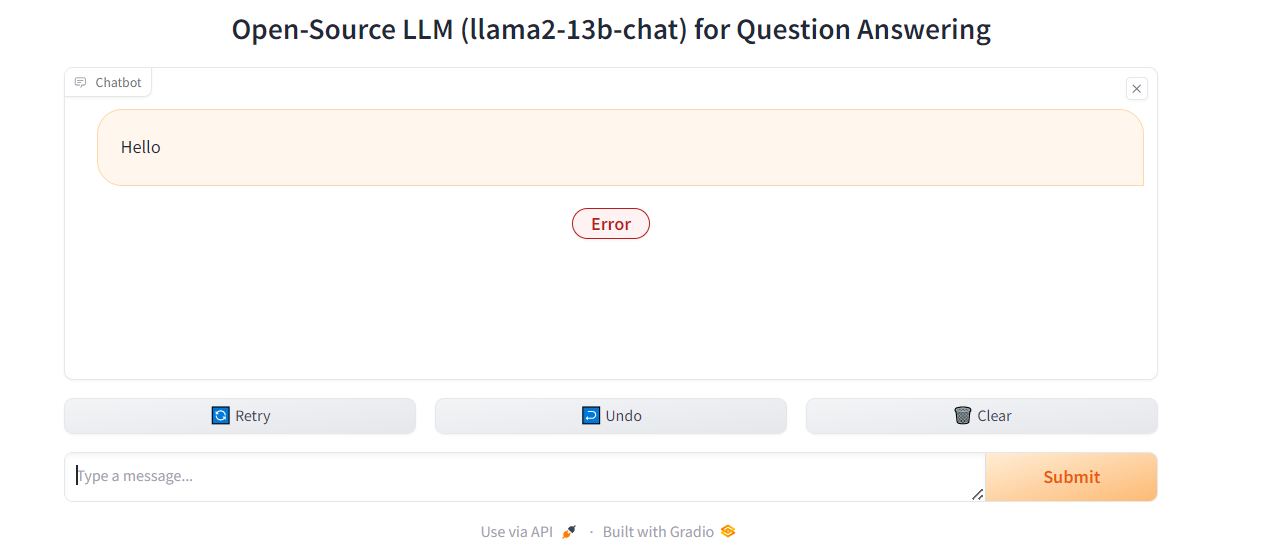
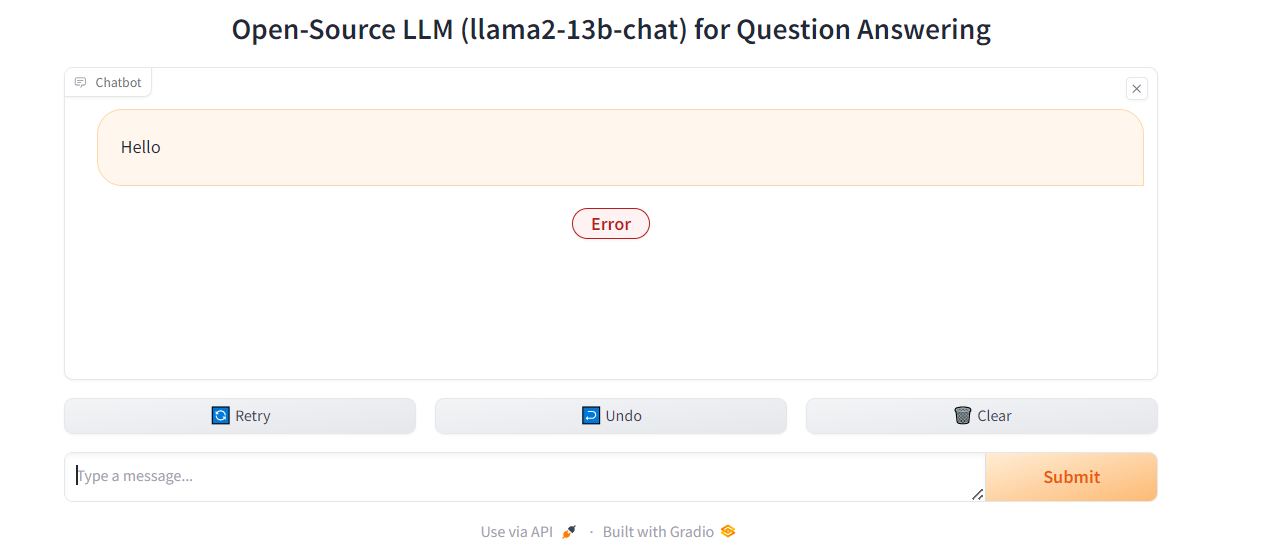

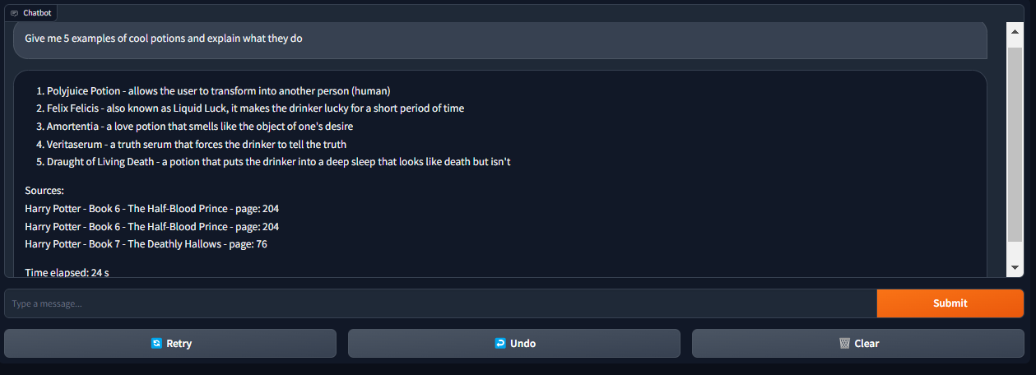

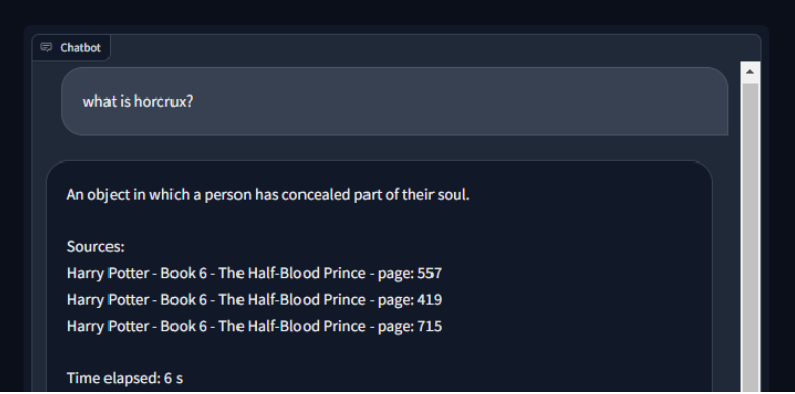

# Conclusions

- Feel free to fork and optimize the code. Lots of things can be improved.

- Things I found had the most impact on models output quality in my experiments:
    - Prompt engineering
    - Bigger models
    - Other models families
    - Splitting: chunk size, overlap
    - Search: Similarity, MMR, k
    - Pipeline parameters (temperature, top_p, penalty)
    - Embeddings function
    - LLM parameters (max len)


- LangChain, Hugging Face and Gradio are awesome libs!

- **<font color='orange'>If you liked this notebook, don't forget to show your support with an Upvote!</font>**

- In case you are interested in LLMs, I also have some other notebooks you might want to check:

    - [Instruction Finetuning](https://www.kaggle.com/code/hinepo/llm-instruction-finetuning-wandb)
    - [Preference Finetuning - LLM Alignment](https://www.kaggle.com/code/hinepo/llm-alignment-preference-finetuning)
    - [Synthetic Data for Finetuning](https://www.kaggle.com/code/hinepo/synthetic-data-creation-for-llms)
    - [Safeguards and Guardrails](https://www.kaggle.com/code/hinepo/llm-safeguards-and-guardrails)
    
___

🦜🔗🤗

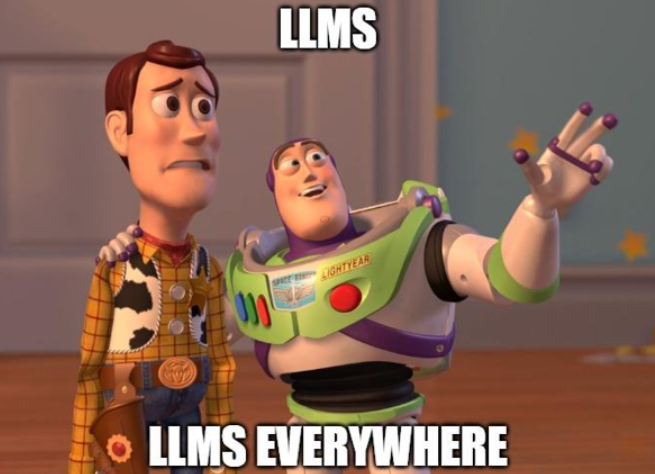